## Argo Test

In this notebook I'm attempting to replicate some of the glider results with Argo data in the region of 30E-40E and 50S-55S.

In [2]:
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

## Load Points, Make Profiles, Remove Profiles with Sampling Frequency Less Than 2m

In [76]:
ds = argo_loader.region([30,40,-55,-50, 200,2000]).to_xarray()

In [319]:
ds=ds.argo.point2profile()

In [320]:
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    #ds_prof=ds.argo.point2profile()
    median_dp=ds_prof.PRES.where(ds_prof.PRES<depth_max).where(ds_prof.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds_prof.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [331]:
CT_interp=get_ds_interp(ds,200,2000,3)

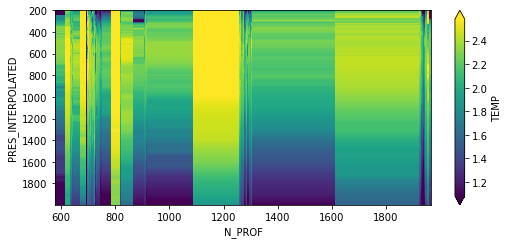

In [332]:
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

## Filtering Analysis

In [333]:
#use np.logspace (linspace? arange?) instead of quant

def get_ds_filt(ds,first,last,step):
    quant=int((last-first)/step)+1
    temp=np.zeros((ds.N_PROF.shape[0],ds.PRES_INTERPOLATED.shape[0],quant))
    filter_scales=np.zeros((quant))

    for n,sig in enumerate(range(first,last+1,step)):
        sigma=sig/4/np.sqrt(12)
        temp[:,:,n]=filter.gaussian_filter1d(ds,sigma=sigma,mode='nearest')
        filter_scales[n]=sig
    
    ds_filt=xr.DataArray(temp, dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
            coords={'N_PROF':ds.N_PROF,'PRES_INTERPOLATED':ds.PRES_INTERPOLATED,'FILT_SCALE':filter_scales})
    
    return ds_filt

In [336]:
CT_filt=get_ds_filt(CT_interp,10,300,5)

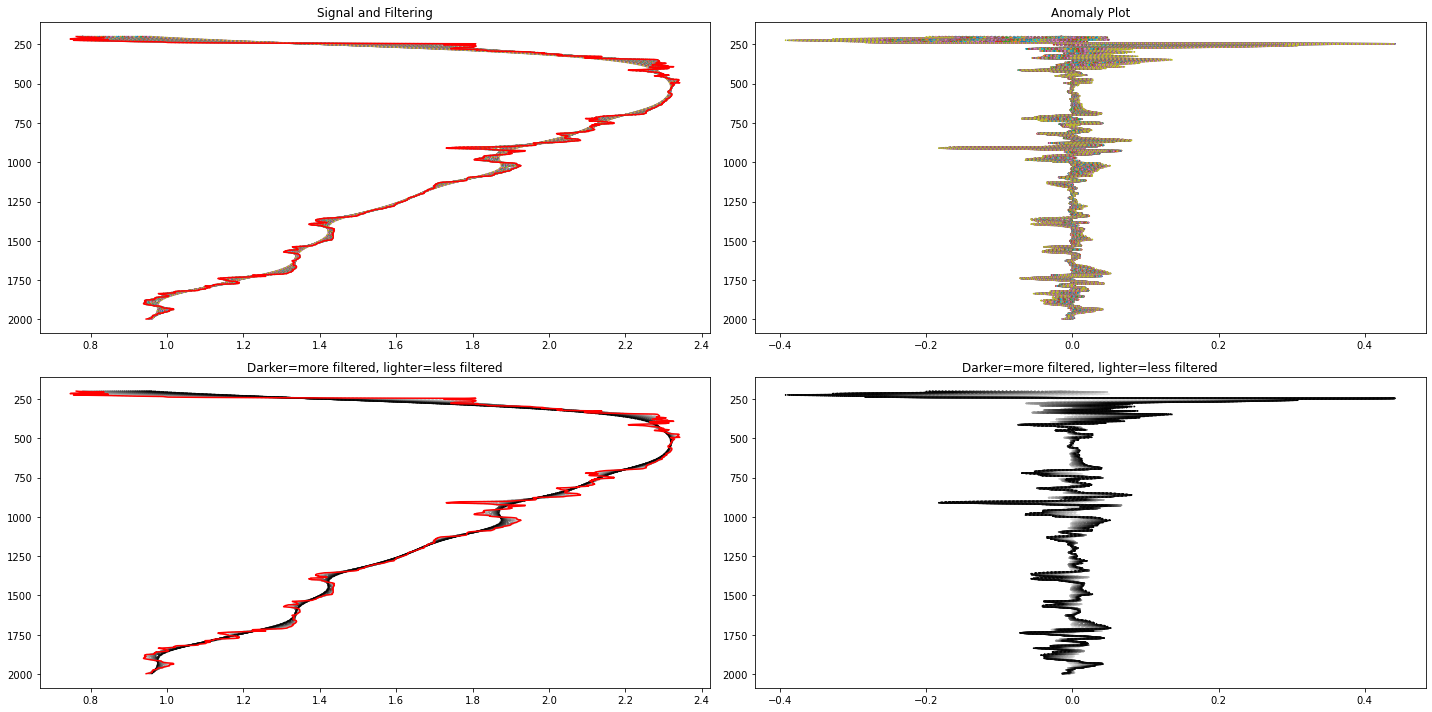

In [337]:
plt.figure(figsize=(20,10))
color=np.arange(0.01,1.01,1/quant)
color=np.flip(color,0)
prof_num=CT_filt.N_PROF[0]
prof=CT_interp.sel(N_PROF=prof_num)

plt.subplot(2,2,1)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")

plt.subplot(2,2,2)
plt.gca().invert_yaxis()
plt.title("Anomaly Plot")

plt.subplot(2,2,3)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

plt.subplot(2,2,4)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

for n,sigma in enumerate(range(first, last+1, step)):
    filt=CT_filt.sel(N_PROF=prof_num,FILT_SCALE=sigma)
    anom=prof-filt
    
    plt.subplot(2,2,1)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,2)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,3)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))
    
    plt.subplot(2,2,4)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))

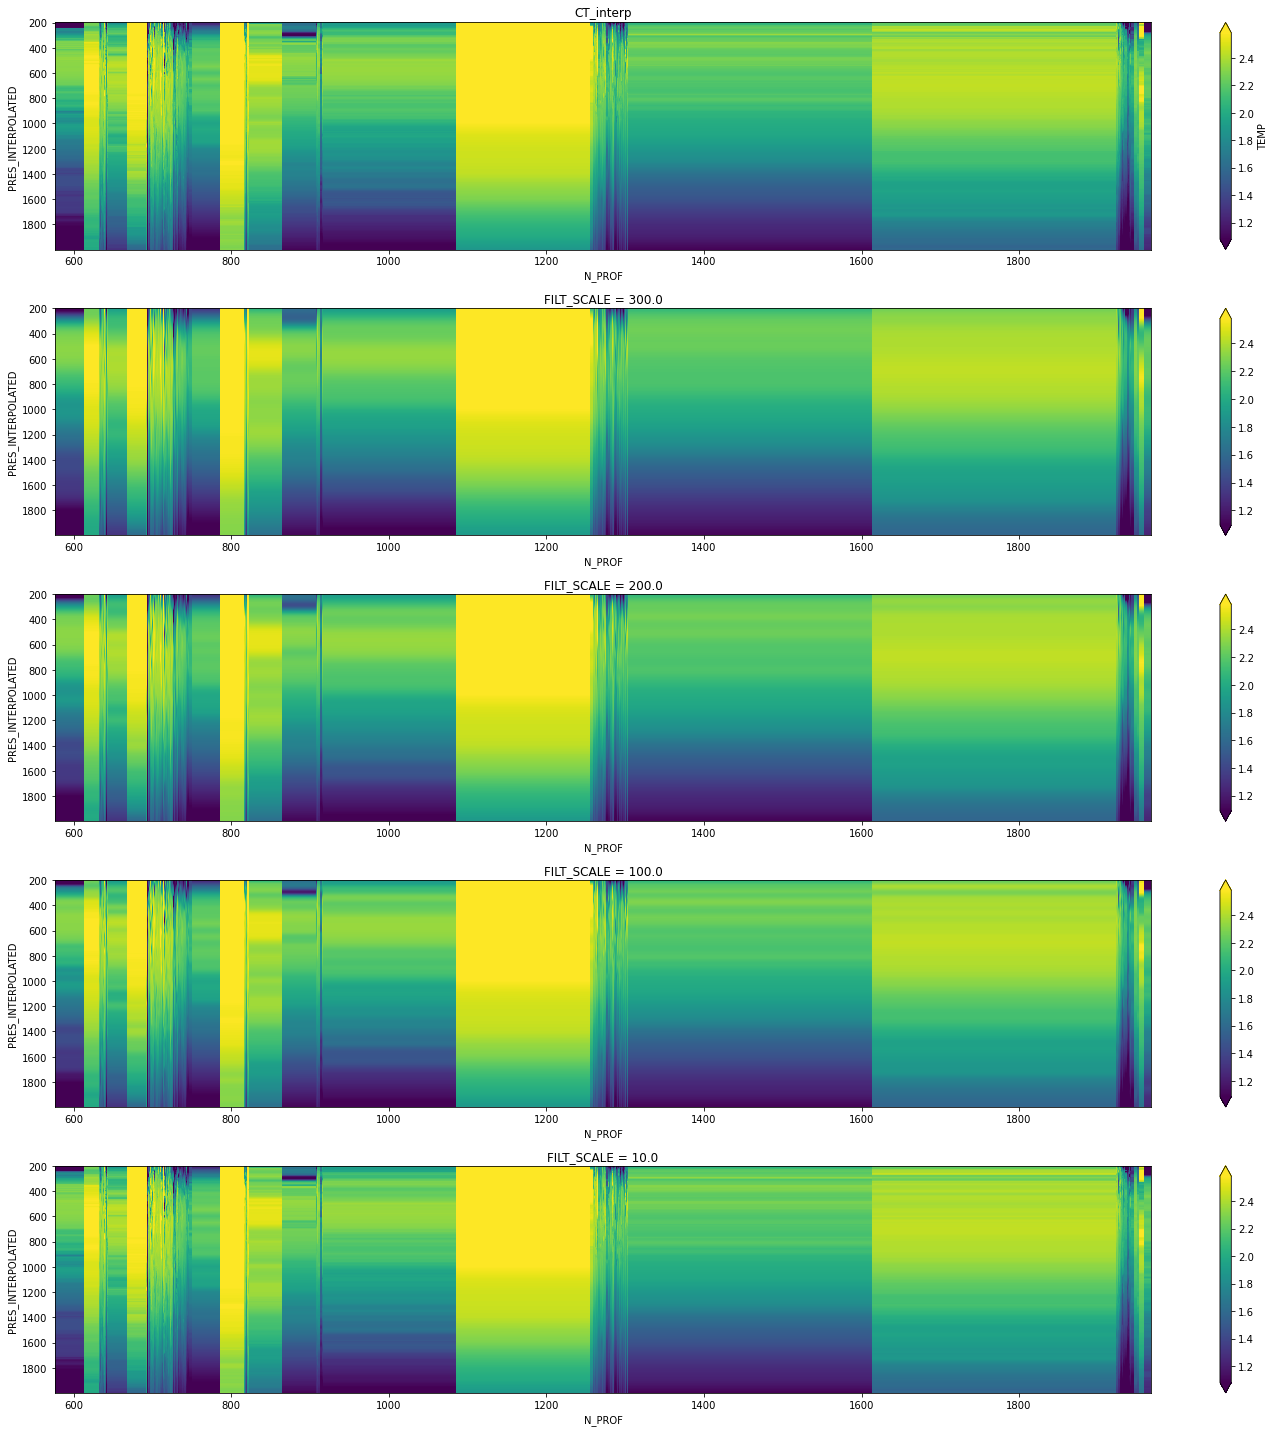

In [338]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
CT_interp.plot(y='PRES_INTERPOLATED',robust=True)
plt.title("CT_interp")
plt.gca().invert_yaxis()

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(FILT_SCALE=sig)
    plt.subplot(5,1,n+2)
    filt.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

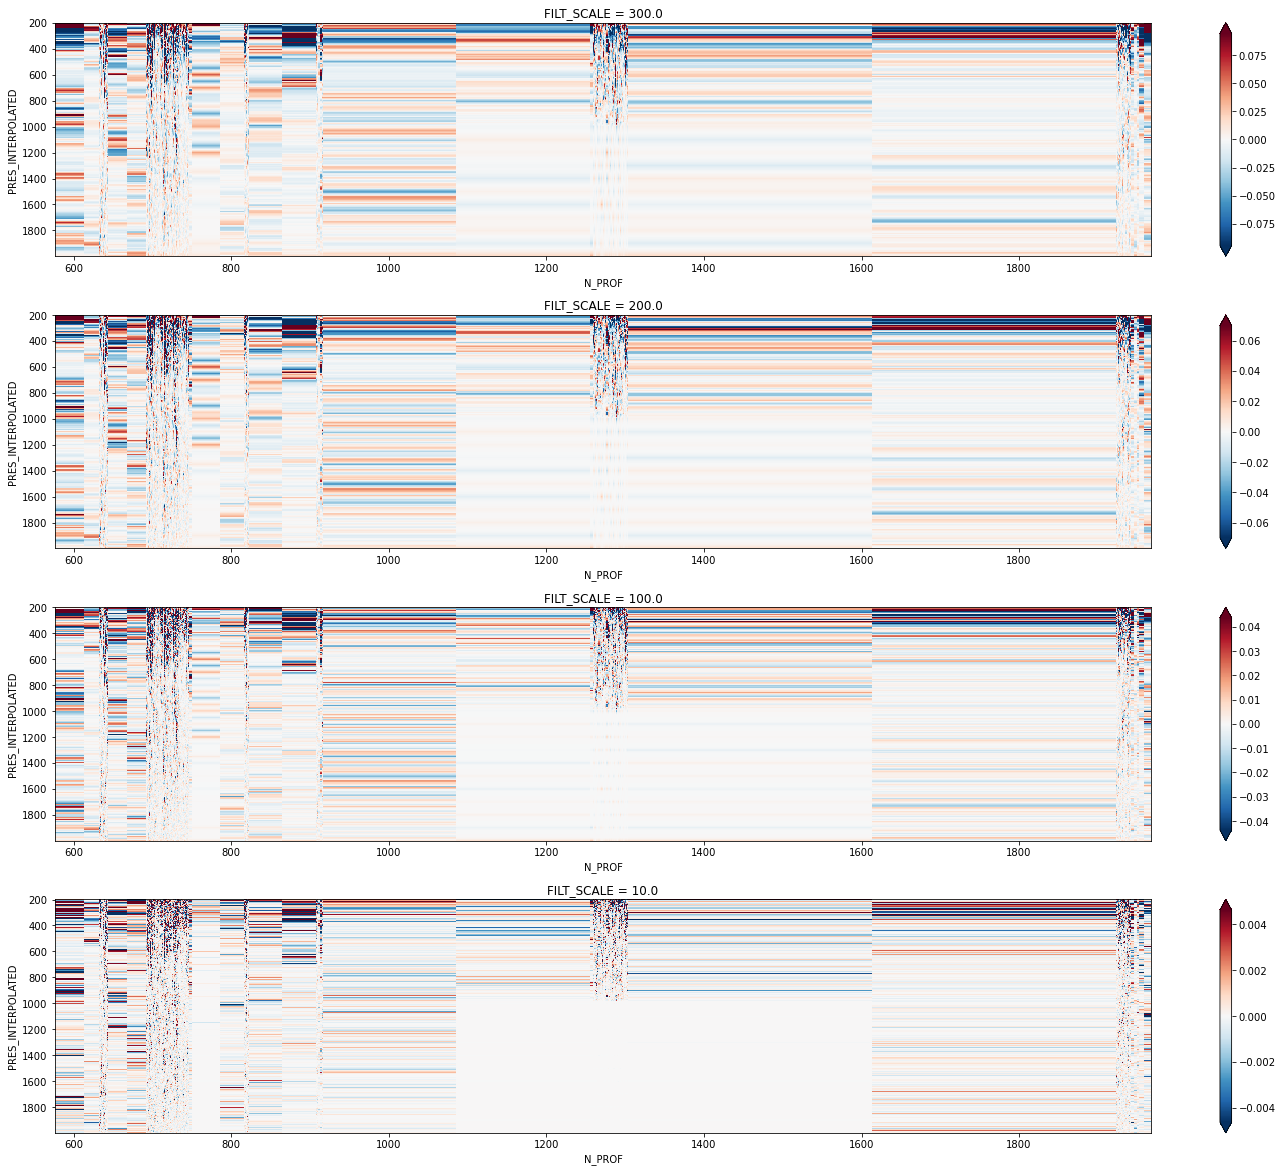

In [339]:
plt.figure(figsize=(20,20))

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(FILT_SCALE=sig)
    anom=filt-CT_interp
    plt.subplot(5,1,n+1)
    anom.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

In [340]:
var_scale=np.zeros(quant)

for n,sigma in enumerate(range(first,last+1,step)):
    prof=CT_filt.sel(FILT_SCALE=sigma)
    var_scale[n]=(prof-CT_interp).var()

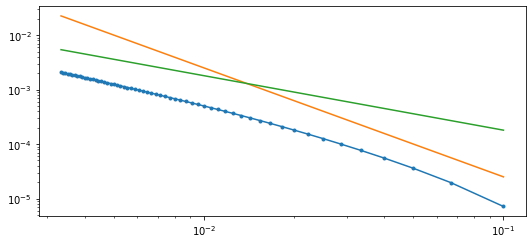

In [341]:
#working on a log axis will uniformly space points here
#can reduce the number of filters that are applied

plt.plot(1/CT_filt.FILT_SCALE,var_scale,'.-')
plt.xscale('log')
plt.yscale('log')

x=1/CT_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1

plt.plot(x,y_2)
plt.plot(x,y_1)

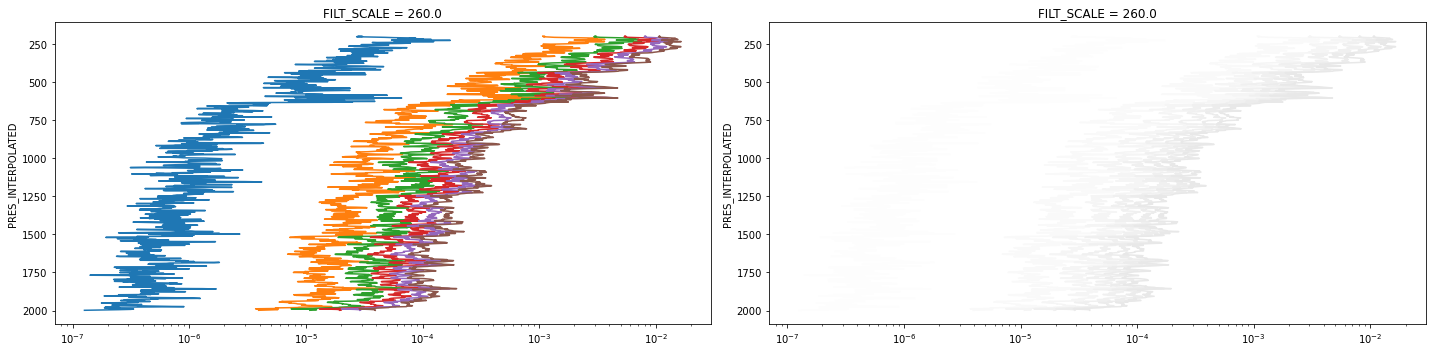

In [342]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
plt.gca().invert_yaxis()
plt.xscale('log')

for n,sig in enumerate(range(first,last+1,step*10)):
    prof=CT_filt.sel(FILT_SCALE=sig)
    
    plt.subplot(1,2,1)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig)
    
    plt.subplot(1,2,2)
    (prof-CT_interp).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sigma,color=str(color[n]))

In [343]:
interp_1000_3=get_ds_interp(ds,0,1000,3)
interp_2000_3=get_ds_interp(ds,1000,2000,3)
interp_1000_12=get_ds_interp(ds,0,1000,12)
interp_2000_12=get_ds_interp(ds,1000,2000,12)

In [344]:
filt_1000_3=get_ds_filt(interp_1000_3,10,300,5)
filt_2000_3=get_ds_filt(interp_2000_3,10,300,5)
filt_1000_12=get_ds_filt(interp_1000_12,10,300,5)
filt_2000_12=get_ds_filt(interp_2000_12,10,300,5)

In [345]:
var_1000_3=np.zeros(quant)
var_2000_3=np.zeros(quant)
var_1000_12=np.zeros(quant)
var_2000_12=np.zeros(quant)

for n,sigma in enumerate(range(first,last+1,step)):
    prof_1000_3=filt_1000_3.sel(FILT_SCALE=sigma,method='nearest')
    var_1000_3[n]=(prof_1000_3-interp_1000_3).var()
    
    prof_2000_3=filt_2000_3.sel(FILT_SCALE=sigma,method='nearest')
    var_2000_3[n]=(prof_2000_3-interp_2000_3).var()
    
    prof_1000_12=filt_1000_12.sel(FILT_SCALE=sigma,method='nearest')
    var_1000_12[n]=(prof_1000_12-interp_1000_12).var()
    
    prof_2000_12=filt_2000_12.sel(FILT_SCALE=sigma,method='nearest')
    var_2000_12[n]=(prof_2000_12-interp_2000_12).var()

Text(0.5, 1.0, 'depth: [1000,2000]')

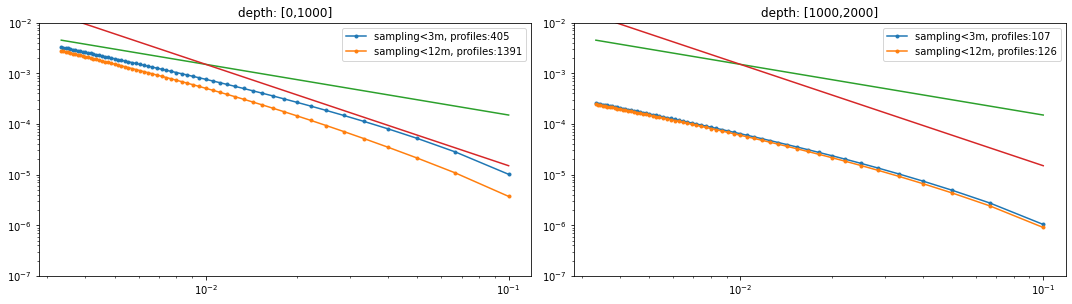

In [358]:
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(1/filt_1000_3.FILT_SCALE,var_1000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_1000_3.N_PROF.shape[0]))
plt.plot(1/filt_1000_12.FILT_SCALE,var_1000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_1000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_1000_3.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.legend()
plt.ylim(10**-7,10**-2)
plt.title("depth: [0,1000]")

plt.subplot(2,2,2)
plt.plot(1/filt_2000_3.FILT_SCALE,var_2000_3,'.-',label='sampling<3m, profiles:{}'.format(interp_2000_3.N_PROF.shape[0]))
plt.plot(1/filt_2000_12.FILT_SCALE,var_2000_12,'.-',label='sampling<12m, profiles:{}'.format(interp_2000_12.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
x=1/filt_2000_3.FILT_SCALE
y_1=1.5*10**-5*x**-1
y_2=1.5*10**-7*x**-2
plt.plot(x,y_1)
plt.plot(x,y_2)
plt.legend()
plt.ylim(10**-7,10**-2)
plt.title("depth: [1000,2000]")